# **Download Dataset from kaggle**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vencerlanz09/plastic-paper-garbage-bag-synthetic-images")

print("Path to dataset files:", path)

100%|██████████| 451M/451M [00:20<00:00, 22.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vencerlanz09/plastic-paper-garbage-bag-synthetic-images/versions/1


#**Import libraries i will use**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from sklearn.model_selection import train_test_split
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

import os
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter

from keras.layers import Flatten, Dense
from keras.models import Model
from keras.applications.mobilenet import MobileNet
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import tensorflow as tf
from tensorflow import keras



# **Show image sample**



(300, 300, 3)


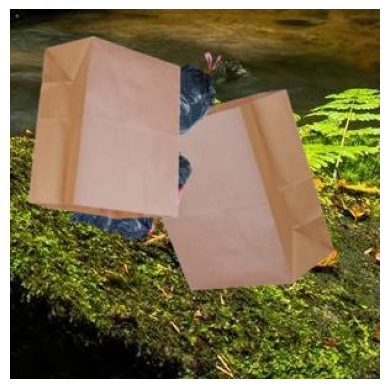

In [ ]:
image_path = '/root/.cache/kagglehub/datasets/vencerlanz09/plastic-paper-garbage-bag-synthetic-images/versions/1/ImageClassesCombinedWithCOCOAnnotations/images_raw/00000010.jpg'
# Read the image
img = mpimg.imread(image_path)

print(img.shape)
# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

# **check images size in every class**

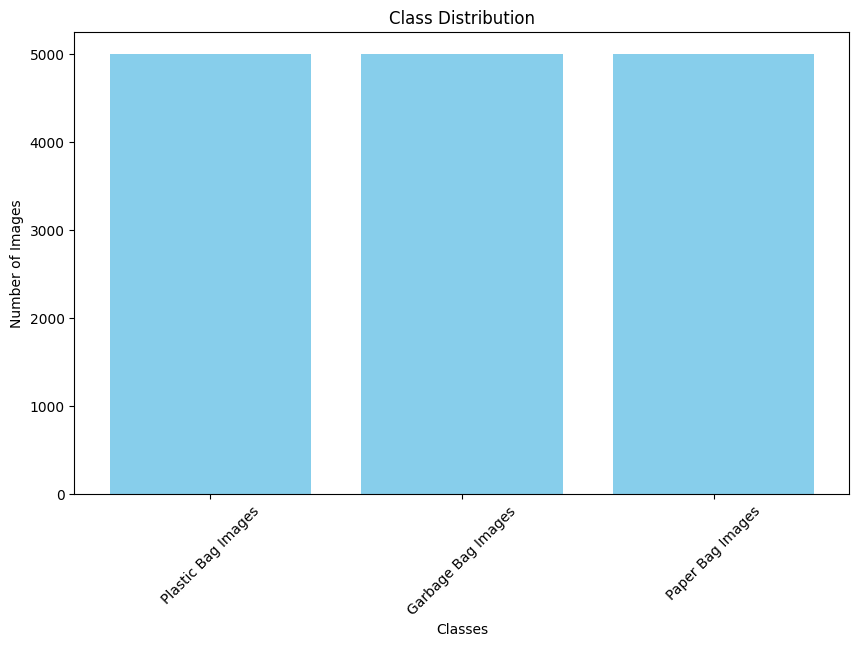

In [ ]:


# Path to your dataset
dataset_path = Path('/root/.cache/kagglehub/datasets/vencerlanz09/plastic-paper-garbage-bag-synthetic-images/versions/1/Bag Classes/Bag Classes')

# Initialize a Counter to store class counts
class_counts = Counter()

# Iterate through each class folder in the dataset
for class_folder in os.listdir(dataset_path):
    class_folder_path = dataset_path / class_folder
    if os.path.isdir(class_folder_path):
        # Count the number of files in each class folder
        num_files = len(os.listdir(class_folder_path))
        class_counts[class_folder] = num_files

# Plot the class counts
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()


In [ ]:
image_dir = Path(dataset_path)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# **show sample of images with labels**

[10865  7151  2105 12683  4626  1324  4339  6312 11830  7929  3612  8696
 14712  2396 13803    91]


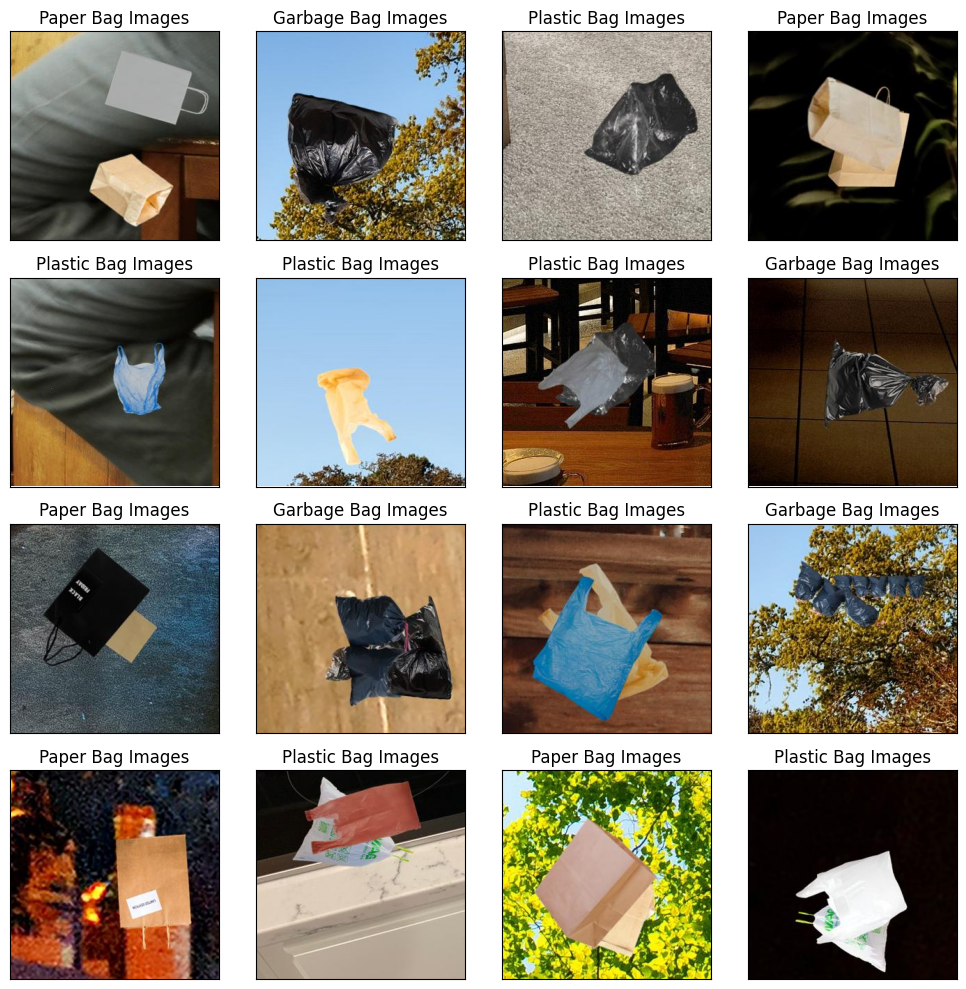

In [ ]:
random_index = np.random.randint(0, len(image_df), 16)
print(random_index)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# **Spilt data into 80% train and  20% test**

In [ ]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)
train_df.shape

(12000, 2)

In [ ]:
test_df.shape


(3000, 2)

In [ ]:

train_set = ImageDataGenerator(
        rescale=1./255,
    validation_split=0.2

)

test_set = ImageDataGenerator(
    rescale=1./255,
)

In [ ]:



# Split the data into three categories.
train_images = train_set.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_set.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_set.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 9600 validated image filenames belonging to 3 classes.
Found 2400 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.


# **First using MobileNet pertrained CNN model**

In [ ]:
# Load the MobileNet base model
base_model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model layers to prevent feature extraction training
for layer in base_model.layers:
    layer.trainable = False


# Define new model
X = Flatten()(base_model.output)
X = Dense(128, activation='relu')(X)  # Reduced neurons
X = Dropout(0.5)(X)
X = Dense(3, activation='softmax')(X)  # Final classification layer for 3 classes

# Build the model
model = Model(inputs=base_model.input, outputs=X)

# Compile the model with a high learning rate
model.compile(optimizer=Adam(learning_rate=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,651,907 (36.82 MB)

 Trainable params: 6,423,043 (24.50 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [ ]:


# ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',     # Save model to this file
    monitor='val_loss', # Monitor validation loss
    save_best_only=True, # Save the model only when validation loss improves
    verbose=1,          # Print messages when saving the model
    save_weights_only=False,  # Save the entire model (architecture + weights)
    mode='min',         # 'min' means to save the model when validation loss is minimized
)

reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


# Train the model for exactly 10 epochs
history = model.fit(
    train_images,
    epochs=20,                     # Train for up to 10 epochs
    validation_data=val_images,
    callbacks=[reduce_lr_callback, model_checkpoint]  # Add ReduceLROnPlateau, ModelCheckpoint, and EarlyStopping
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7760 - loss: 7.5082
Epoch 1: val_loss improved from inf to 0.18068, saving model to best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - accuracy: 0.7764 - loss: 7.4720 - val_accuracy: 0.9492 - val_loss: 0.1807 - learning_rate: 0.0050
Epoch 2/20
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8864 - loss: 0.3251
Epoch 2: val_loss improved from 0.18068 to 0.14880, saving model to best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - accuracy: 0.8864 - loss: 0.3251 - val_accuracy: 0.9458 - val_loss: 0.1488 - learning_rate: 0.0050
Epoch 3/20
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9062 - loss: 0.2842
Epoch 3: val_loss did not improve from 0.14880
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.9062 - loss: 0.2843 - val_accuracy: 0.9542 - val_loss: 0.1644 - learning_rate: 0.0050
Epoch 4/20
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9091 - loss: 0.2783
Epoch 4: val_loss did

In [ ]:
# Retrieve final training accuracy and loss
train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Training Loss: {train_loss:.4f}")
#Validation set Accuracy
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(test_images)
print(f"Testing Accuracy: {test_acc:.4f}")
print(f"Testing Loss: {test_loss:.4f}")

Final Training Accuracy: 0.9837
Final Training Loss: 0.0573
Final Validation Accuracy: 0.9821
Final Validation Loss: 0.1219
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.9827 - loss: 0.1266
Testing Accuracy: 0.9803
Testing Loss: 0.1521


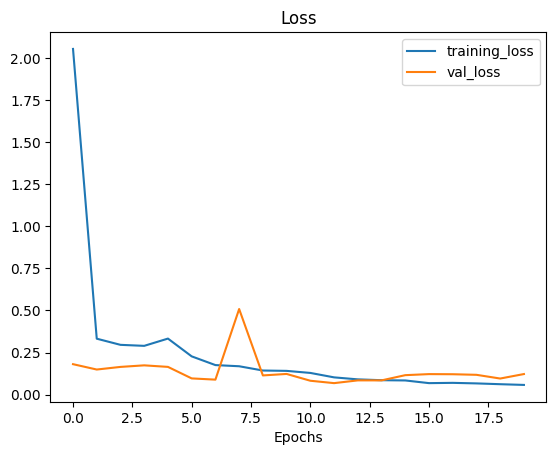

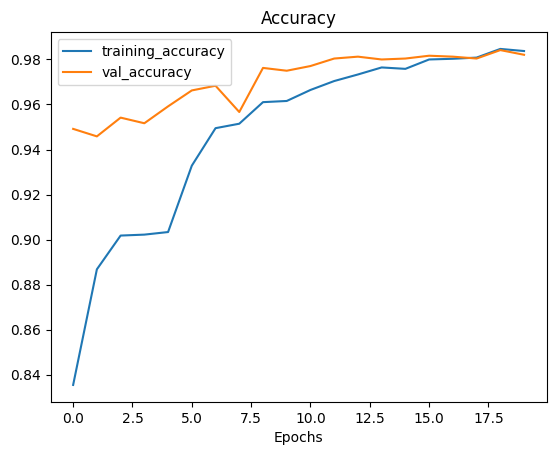

In [ ]:
import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step
The first 10 predictions: ['Paper Bag Images', 'Garbage Bag Images', 'Paper Bag Images', 'Plastic Bag Images', 'Garbage Bag Images', 'Garbage Bag Images', 'Plastic Bag Images', 'Plastic Bag Images', 'Plastic Bag Images', 'Plastic Bag Images']


In [ ]:
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score      support
Garbage Bag Images   0.985729  0.996907  0.991287   970.000000
Paper Bag Images     0.969368  0.987915  0.978554   993.000000
Plastic Bag Images   0.986097  0.957570  0.971624  1037.000000
accuracy             0.980333  0.980333  0.980333     0.980333
macro avg            0.980398  0.980798  0.980488  3000.000000
weighted avg         0.980441  0.980333  0.980275  3000.000000

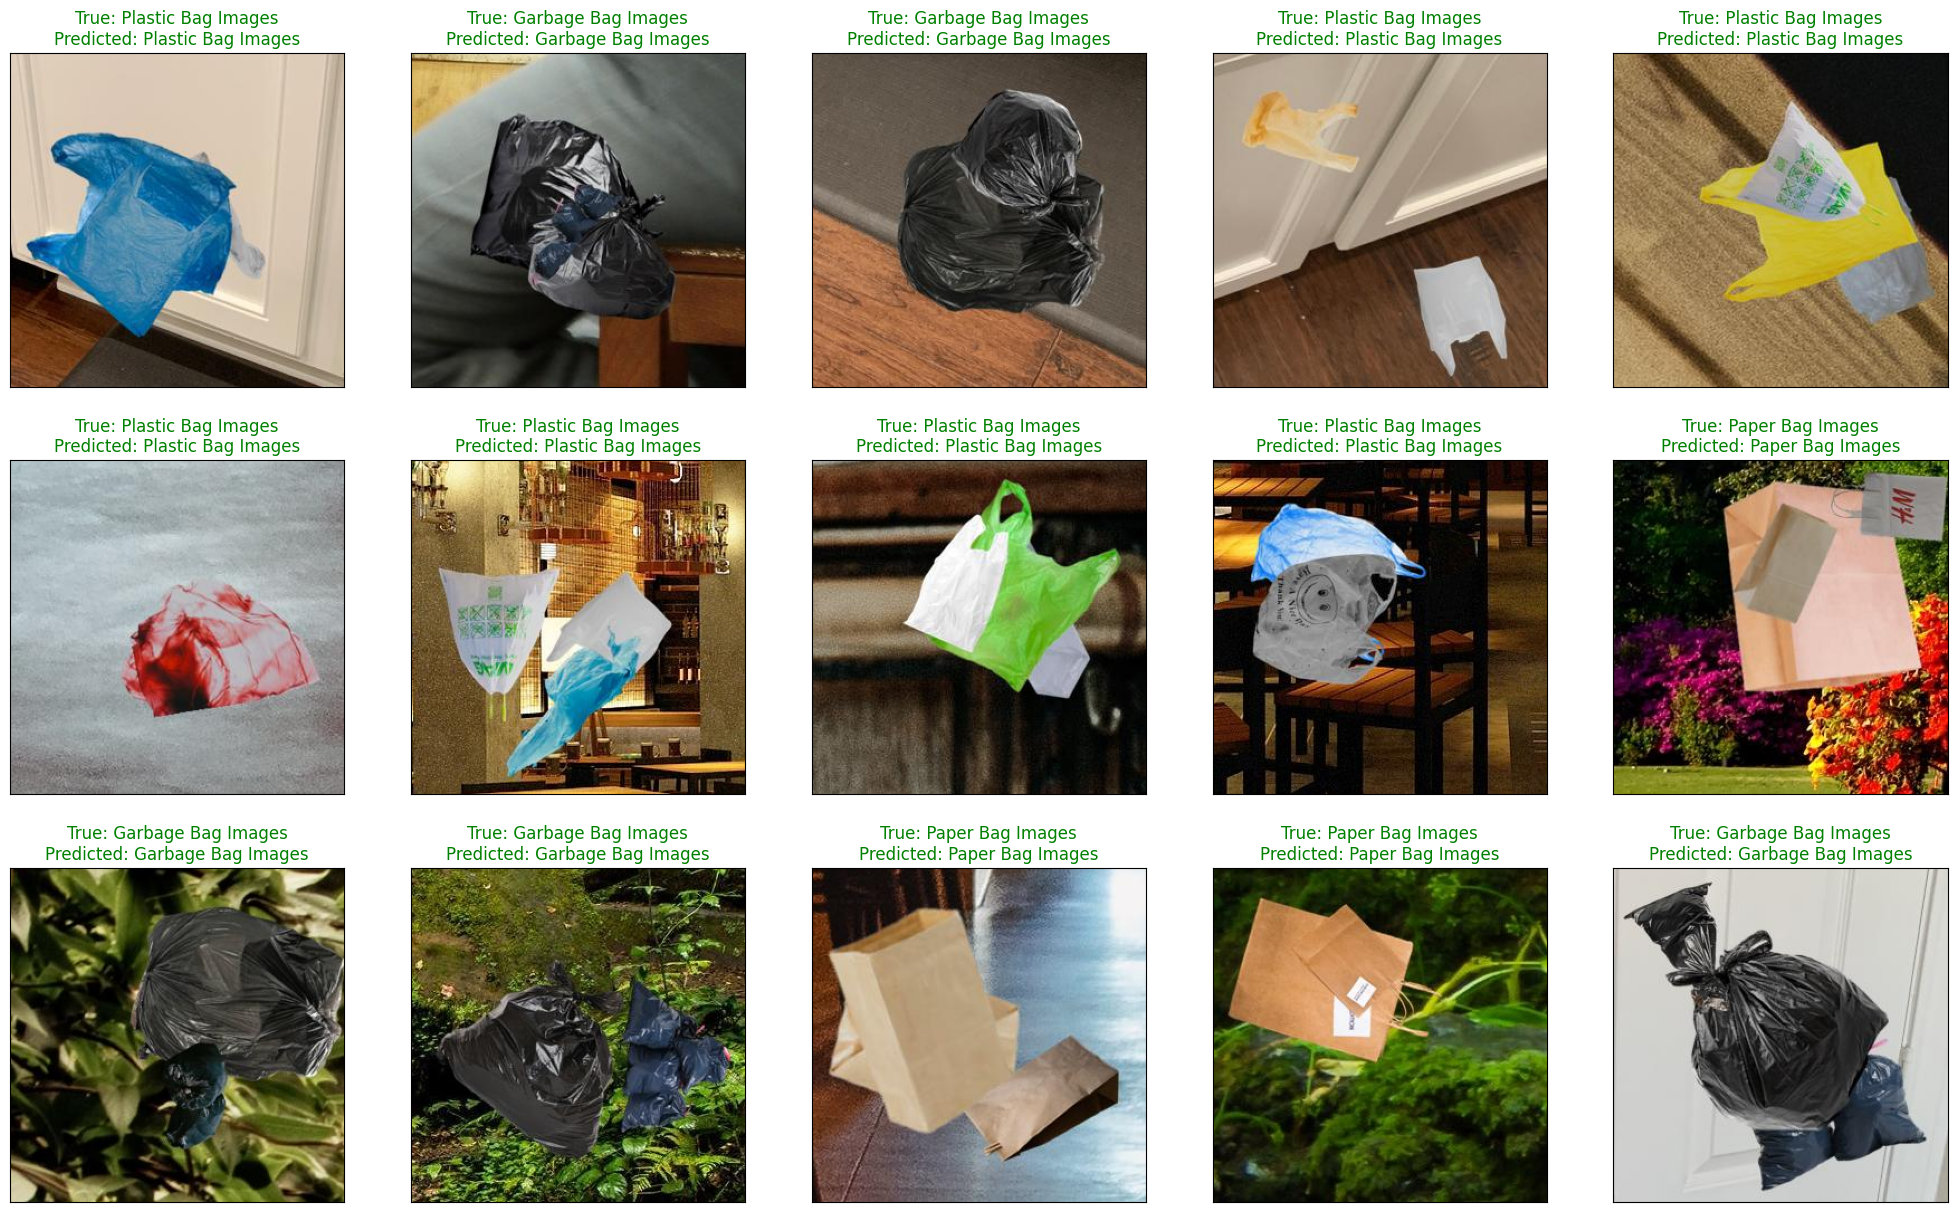

<Figure size 640x480 with 0 Axes>

In [ ]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()


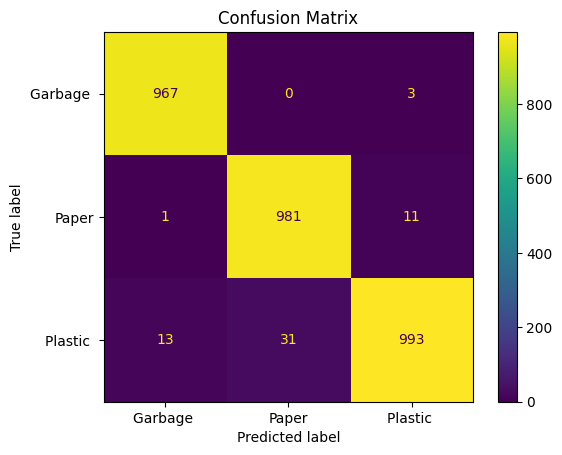

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Class names
class_names = ['Garbage ', 'Paper', 'Plastic ']

# Compute confusion matrix
cm = confusion_matrix(y_test, pred)

# Display confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.viridis)  # You can choose any colormap you like
plt.title("Confusion Matrix")
plt.show()


Model loaded successfully!
Please upload an image:


Saving grapage.jpg to grapage.jpg
Image grapage.jpg uploaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


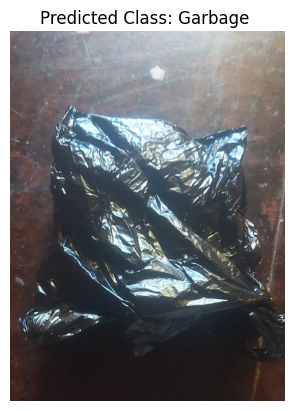

Prediction Probabilities: [[1.0000000e+00 4.3294237e-40 1.1825922e-16]]
Predicted Class: Garbage 


In [ ]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt

# Function to upload an image file from the local device
def upload_image():
    print("Please upload an image:")
    uploaded = files.upload()  # Upload file(s) from your device
    image_path = list(uploaded.keys())[0]  # Get the uploaded file name
    print(f"Image {image_path} uploaded successfully!")
    return image_path

# Function to preprocess the image and predict the class
def predict_image(image_path, model, class_labels):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))  # Resize to 224x224 for MobileNet
    img_array = img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess for MobileNet

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]  # Get the highest probability index

    # Display the image and prediction
    plt.imshow(plt.imread(image_path))
    plt.title(f"Predicted Class: {class_labels[predicted_class]}")
    plt.axis('off')
    plt.show()

    # Print detailed results
    print(f"Prediction Probabilities: {predictions}")
    print(f"Predicted Class: {class_labels[predicted_class]}")

# Load your trained model
model_path = "best_model.keras"  # Path to your saved model
model = tf.keras.models.load_model(model_path)
print("Model loaded successfully!")

# Define your class labels
class_labels = ['Garbage ', 'Paper', 'Plastic ']

# Upload an image and make a prediction
image_path = upload_image()  # Upload image file
predict_image(image_path, model, class_labels)  # Predict the class


Model loaded successfully!
Please upload an image:


Saving plastic.jpg to plastic.jpg
Image plastic.jpg uploaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


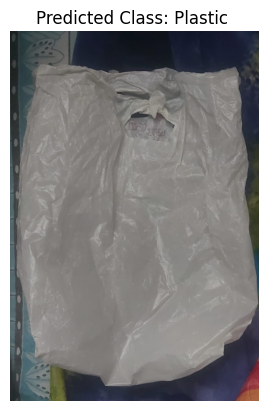

Prediction Probabilities: [[0.0030648  0.01371837 0.98321676]]
Predicted Class: Plastic 


In [ ]:

model_path = "best_model.keras"  # Path to your saved model
model = tf.keras.models.load_model(model_path)
print("Model loaded successfully!")

# Define your class labels
class_labels = ['Garbage ', 'Paper', 'Plastic ']

# Upload an image and make a prediction
image_path = upload_image()  # Upload image file
predict_image(image_path, model, class_labels)  # Predict the class
